In [42]:
import pandas as pd
import numpy as np
from sklearn import ensemble, model_selection, decomposition, preprocessing, tree, svm, linear_model
from matplotlib import pyplot as plt

In [3]:
# 进一步探索泰坦尼克号数据
data = pd.read_csv('./data/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
data.drop(['Cabin'],axis=1, inplace=True)

In [6]:
data.drop(['Name'],axis=1, inplace=True)

In [7]:
data.drop(['Ticket'],axis=1, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


In [9]:
# 对性别和Embarked进行独热编码
en = preprocessing.OneHotEncoder()
en_data = en.fit_transform(data['Sex'].values.reshape(-1, 1)).toarray()
en_data

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [10]:
en.categories_

[array(['female', 'male'], dtype=object)]

In [11]:
# 说明data的index是连续的
[*data.index] == [*range(0, 891)]

True

In [12]:
# 对性别进行独热编码 在拼接到数据上
data = pd.concat([data, pd.DataFrame(en_data, columns=['female', 'male'], index=data.index)], axis=1)

In [13]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,female,male
0,1,0,3,male,22.0,1,0,7.2500,S,0.0,1.0
1,2,1,1,female,38.0,1,0,71.2833,C,1.0,0.0
2,3,1,3,female,26.0,0,0,7.9250,S,1.0,0.0
3,4,1,1,female,35.0,1,0,53.1000,S,1.0,0.0
4,5,0,3,male,35.0,0,0,8.0500,S,0.0,1.0


In [14]:
# Embarked 中又两个缺失值值 数量比较少 直接删掉
index = data[data['Embarked'].isnull()].index
data.drop(index=index, inplace=True)


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
female         889 non-null float64
male           889 non-null float64
dtypes: float64(4), int64(5), object(2)
memory usage: 83.3+ KB


In [16]:
# 这要注意的是 data的index已经不连续
[*data.index] == [*range(0, 890)]

False

In [17]:
# 对Embarked进行独热编码
en = preprocessing.OneHotEncoder()
en_data = en.fit_transform(data['Embarked'].values.reshape(-1, 1)).toarray()
# 这要注意一点的是en_data构建DataFrame要指定index，因为这两个的index不匹配
data = pd.concat([data, pd.DataFrame(en_data, columns=['Embarked_C', 'Embarked_Q', 'Embarked_S'], index=data.index)], axis=1)
data.shape

(889, 14)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
female         889 non-null float64
male           889 non-null float64
Embarked_C     889 non-null float64
Embarked_Q     889 non-null float64
Embarked_S     889 non-null float64
dtypes: float64(7), int64(5), object(2)
memory usage: 104.2+ KB


In [19]:
# 删除原来的Sex和Embarked列
data.drop(['Embarked', 'Sex'], axis=1, inplace=True)

In [20]:
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,5,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
female         889 non-null float64
male           889 non-null float64
Embarked_C     889 non-null float64
Embarked_Q     889 non-null float64
Embarked_S     889 non-null float64
dtypes: float64(7), int64(5)
memory usage: 90.3 KB


In [22]:
# 只有age有缺失项 尝试使用随机森林回归进行填充
x_train = data.loc[data['Age'].notnull(), data.columns != 'Age']
y_train = data.loc[data['Age'].notnull(), 'Age']

x_test = data.loc[data['Age'].isnull(), data.columns != 'Age']
y_test = data.loc[data['Age'].isnull(), 'Age']


In [23]:
y_train.shape

(712,)

In [24]:
y_test.shape

(177,)

In [25]:
# 接下来开始使用随机森立回归开始插值  以Age为标签值 剩下的其他的作为特征列
clf = ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(x_train, y_train)
pred = clf.predict(x_test)
pred 

array([39.135 , 44.785 , 17.14  , 27.475 , 18.16  , 24.465 , 41.54  ,
       18.97  , 21.48  , 25.22  , 22.41  , 36.95  , 19.5   , 22.6   ,
       38.54  , 44.805 , 13.7341, 25.27  , 24.46  , 19.48  , 25.705 ,
       33.595 , 30.41  , 26.32  , 22.105 , 27.485 , 55.155 , 14.9325,
       30.4   , 32.495 , 24.98  ,  8.02  , 29.1   , 54.675 ,  4.99  ,
       10.34  , 32.215 , 49.71  , 22.525 , 51.75  , 19.015 ,  8.05  ,
       47.17  , 33.74  ,  6.12  , 27.75  , 25.075 , 23.96  , 23.15  ,
       31.76  , 51.74  , 40.27  , 48.29  , 24.45  , 32.36  , 48.105 ,
       39.425 , 41.865 , 22.785 , 27.95  , 33.15  , 29.75  , 27.69  ,
        8.05  , 24.425 , 33.05  , 28.97  , 31.35  , 48.285 , 30.125 ,
       24.365 , 24.365 , 36.255 , 19.835 , 24.265 , 36.82  , 28.51  ,
       28.8   ,  6.85  , 29.72  , 27.67  , 30.88  , 27.39  , 28.855 ,
       24.275 , 36.05  , 34.14  , 34.71  , 24.31  , 34.86  , 42.62  ,
       34.565 , 36.77  , 39.5   , 26.475 , 24.97  , 47.51  , 39.11  ,
        8.0025, 25.9

In [26]:
data.loc[data['Age'].isnull(), 'Age'] = pred

In [27]:
data.to_csv('./temp/train_data_02.csv', index=False)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
female         889 non-null float64
male           889 non-null float64
Embarked_C     889 non-null float64
Embarked_Q     889 non-null float64
Embarked_S     889 non-null float64
dtypes: float64(7), int64(5)
memory usage: 90.3 KB


In [29]:
# data.index = range(0, 890)
data.reindex(index=range(0, 890))
[*data.index] == [*range(0, 890)]

False

In [30]:
# 然后开始拆分训练集和测试集
# 先分训练集和测试集 
X = data.loc[:, data.columns != 'Survived']
y = data.loc[:, 'Survived']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=66)

In [31]:
for i in [X_train, X_test, y_train, y_test]:
    i.index = range(i.shape[0])

In [32]:
# 接下来开始建立模型 预测数据 因为在单个决策树的效果没有在集成算法上好
# 所以直接上集成算法--随机森林
clf = ensemble.RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
clf.score(X_test, y_test)


0.846441947565543

0.8357635342185905 171


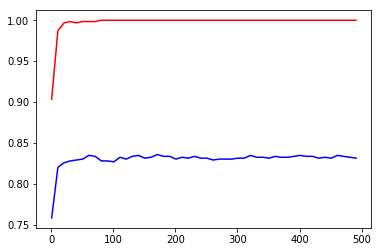

In [33]:
# n_estimators的学习曲线
train_scores = []
test_scores = []
x_ticks = [*range(1, 500, 10)]
for i in range(1, 500, 10):
    clf = ensemble.RandomForestClassifier(n_estimators=i, random_state=66)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()

0.8357763023493361 130


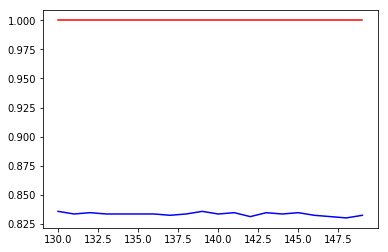

In [34]:
# 细化n_estimators的学习曲线  由下图可知可能出现了过拟合
train_scores = []
test_scores = []
x_ticks = [*range(130, 150)]
for i in range(130, 150):
    clf = ensemble.RandomForestClassifier(n_estimators=i, random_state=66)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()

0.8424923391215525 10


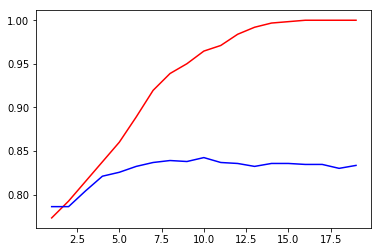

In [35]:
# 接下开调max_depth 画max_depth的学习曲线
train_scores = []
test_scores = []
x_ticks = [*range(1, 20)]
for i in range(1, 20):
    clf = ensemble.RandomForestClassifier(n_estimators=142, random_state=66, max_depth=i)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()

In [36]:
y.value_counts()

0    549
1    340
Name: Survived, dtype: int64

0.842517875383044 1.3265306122448979


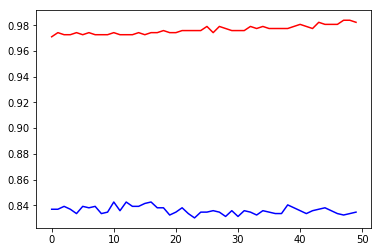

In [37]:
# 因为样本有轻微的样本不均衡问题 再次尝试
train_scores = []
test_scores = []
weight_arr = np.linspace(1, 2, 50)
for weight in weight_arr:
    clf = ensemble.RandomForestClassifier(n_estimators=142, 
                                          random_state=66,
                                          max_depth=11,
                                          class_weight={1:weight,0:1},
                                         )
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(range(len(weight_arr)), train_scores, c='r')
plt.plot(range(len(weight_arr)), test_scores, c='b')
print(max(test_scores), weight_arr[test_scores.index(max(test_scores))])
plt.show()

In [1]:
# 再次尝试网格搜索
param = {'max_depth': [*range(1, 10)],
         'criterion': ('gini', 'entropy'),
         'min_samples_leaf': [*range(2, 50, 5)],
         'min_impurity_decrease':[*np.linspace(0,0.5,20)]
        }

clf = ensemble.RandomForestClassifier(n_estimators=142 ,n_jobs=-1, random_state=66)
gs = model_selection.GridSearchCV(clf, param_grid=param, cv=10, n_jobs=-1)
gs = gs.fit(X, y)

NameError: name 'np' is not defined

0.8346271705822268 1.0


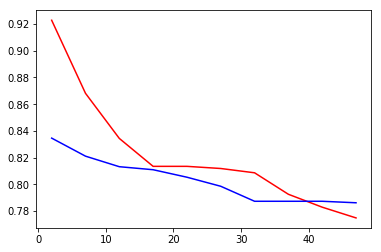

In [39]:
# for 
train_scores = []
test_scores = []
x_ticks = [*range(2, 50, 5)]
for i in range(2, 50, 5):
    clf = ensemble.RandomForestClassifier(n_estimators=142, 
                                          random_state=66,
                                          max_depth=11,
                                          class_weight={1:1,0:1},
                                          min_samples_leaf=i
                                         )
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), weight_arr[test_scores.index(max(test_scores))])
plt.show()

In [43]:
# # 再次换模型进行尝试
# models = [
#     ensemble.RandomForestClassifier(n_estimators=142, random_state=66, max_depth=11),
#     ensemble.GradientBoostingClassifier(),
#     svm.SVC(),
#     linear_model.LogisticRegression()
# ]

# 再次换模型进行尝试
clf = ensemble.GradientBoostingClassifier()
train_score = clf.fit(X_train, y_train).score(X_train, y_train)

mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()

print(train_score, '----', mean_score)

0.9212218649517685 ---- 0.8076864147088866


In [45]:
# 再次换模型进行尝试
clf = svm.SVC(gamma='scale')
train_score = clf.fit(X_train, y_train).score(X_train, y_train)

mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()

print(train_score, '----', mean_score)

0.7427652733118971 ---- 0.5029366700715014


In [47]:
# 再次换模型进行尝试
clf = linear_model.LogisticRegression(solver='lbfgs')
train_score = clf.fit(X_train, y_train).score(X_train, y_train)

mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()

print(train_score, '----', mean_score)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

0.7893890675241158 ---- 0.7907814096016341


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
